In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
bank_customer = pd.read_csv("../Data_Q6/Bank_Customer.csv")

In [3]:
bank_customer.head()

,TransactionID,CustomerID,CustomerDateOfBirth,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2002/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2002/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2002/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2002/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2002/8/16,181156,1762.5


In [10]:
bank_customer.describe()

,CustAccountBalance,TransactionTime,TransactionAmount (INR)
count,1.046198e+06,1.048567e+06,1.048567e+06
mean,1.154035e+05,1.541093e+01,1.574335e+03
std,8.464854e+05,5.127049e+00,6.574743e+03
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.721760e+03,1.200000e+01,1.610000e+02
50%,1.679218e+04,1.600000e+01,4.590300e+02
75%,5.765736e+04,2.000000e+01,1.200000e+03
max,1.150355e+08,2.300000e+01,1.560035e+06


In [4]:
bank_customer.columns

Index(['TransactionID', 'CustomerID', 'CustomerDateOfBirth', 'CustGender',
       'CustLocation', 'CustAccountBalance', 'TransactionDate',
       'TransactionTime', 'TransactionAmount (INR)'],
      dtype='object')

/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23458 (\N{CJK UNIFIED IDEOGRAPH-5BA2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-6237}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36134 (\N{CJK UNIFIED IDEOGRAPH-8D26}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20313 (\N{CJK UNIFIED IDEOGRAPH-4F59}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from c

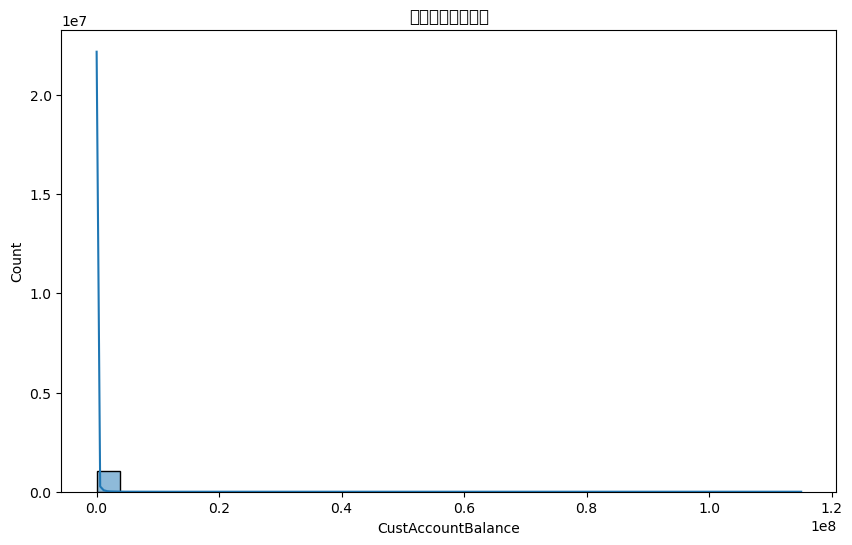

In [8]:
# 客户账户余额分布
plt.figure(figsize=(10,6))
sns.histplot(bank_customer['CustAccountBalance'], bins=30, kde=True)
plt.title('客户账户余额分布')
plt.show()

/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26131 (\N{CJK UNIFIED IDEOGRAPH-6613}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from c

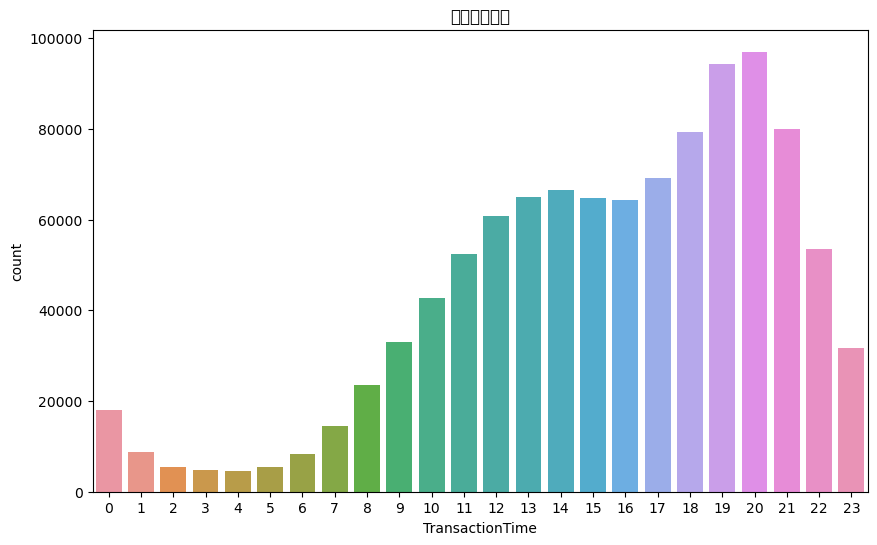

In [9]:
# 交易时间分布
bank_customer['TransactionTime'] = bank_customer['TransactionTime'] // 10000  # 将时间转换为小时
plt.figure(figsize=(10,6))
sns.countplot(data=bank_customer, x='TransactionTime')
plt.title('交易时间分布')
plt.show()

/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23458 (\N{CJK UNIFIED IDEOGRAPH-5BA2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-6237}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21035 (\N{CJK UNIFIED IDEOGRAPH-522B}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from c

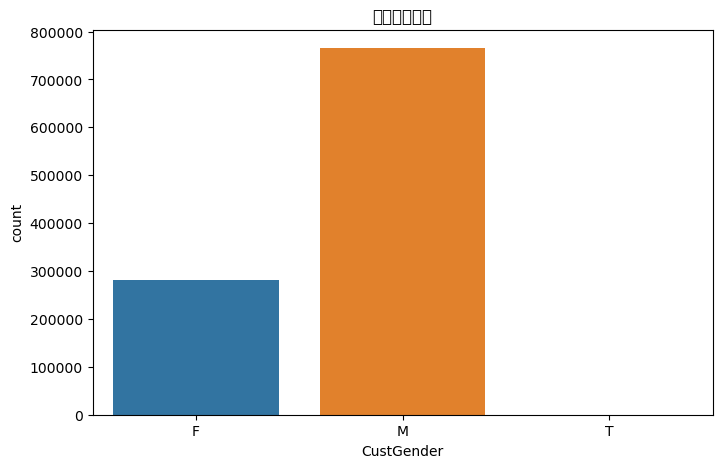

In [11]:
plt.figure(figsize=(8, 5))
sns.countplot(data=bank_customer, x='CustGender')
plt.title('客户性别分布')
plt.show()


/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20132 (\N{CJK UNIFIED IDEOGRAPH-4EA4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26131 (\N{CJK UNIFIED IDEOGRAPH-6613}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27599 (\N{CJK UNIFIED IDEOGRAPH-6BCF}) missing from c

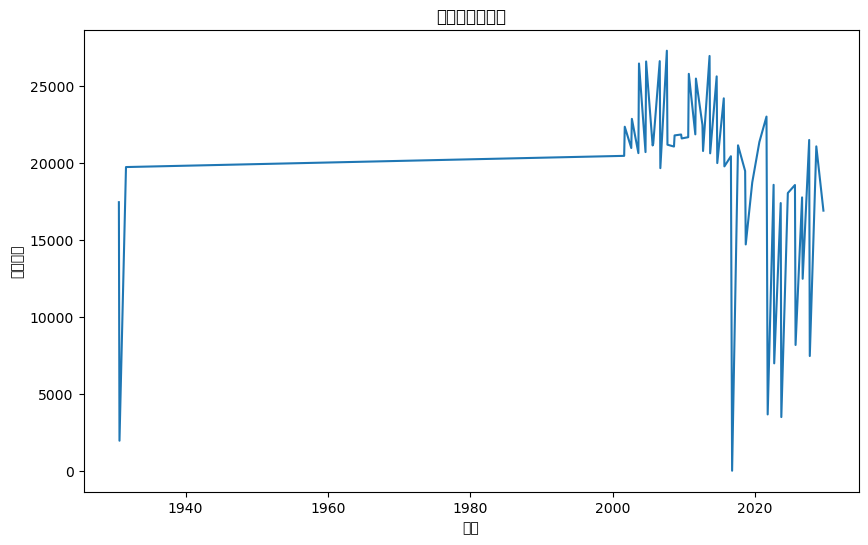

In [13]:
bank_customer['TransactionDate'] = pd.to_datetime(bank_customer['TransactionDate'])
daily_transactions = bank_customer.groupby(bank_customer['TransactionDate'].dt.date).size()
plt.figure(figsize=(10, 6))
daily_transactions.plot(kind='line')
plt.title('每日交易量分布')
plt.ylabel('交易数量')
plt.xlabel('日期')
plt.show()


/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23458 (\N{CJK UNIFIED IDEOGRAPH-5BA2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25143 (\N{CJK UNIFIED IDEOGRAPH-6237}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36134 (\N{CJK UNIFIED IDEOGRAPH-8D26}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20313 (\N{CJK UNIFIED IDEOGRAPH-4F59}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from c

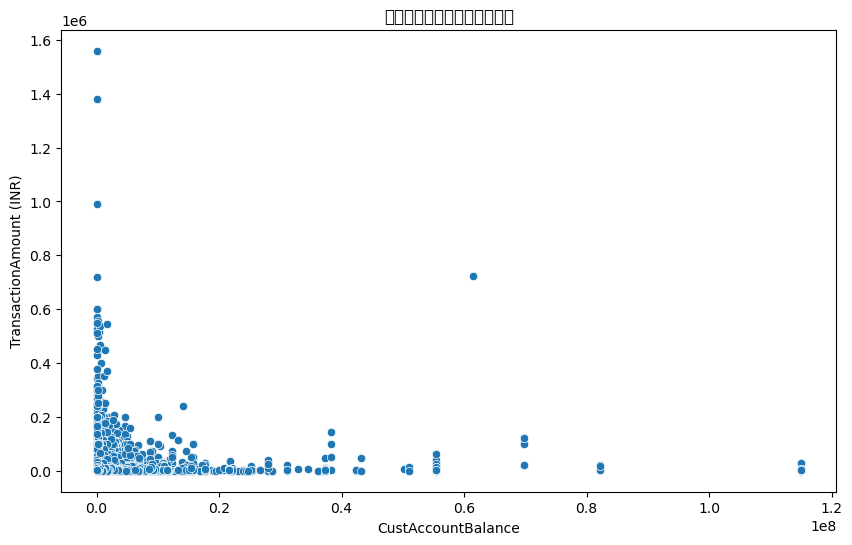

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=bank_customer, x='CustAccountBalance', y='TransactionAmount (INR)')
plt.title('客户账户余额与交易金额关系')
plt.show()


/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21516 (\N{CJK UNIFIED IDEOGRAPH-540C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22320 (\N{CJK UNIFIED IDEOGRAPH-5730}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21306 (\N{CJK UNIFIED IDEOGRAPH-533A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/jason/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30340 (\N{CJK UNIFIED IDEOGRAPH-7684}) missing from c

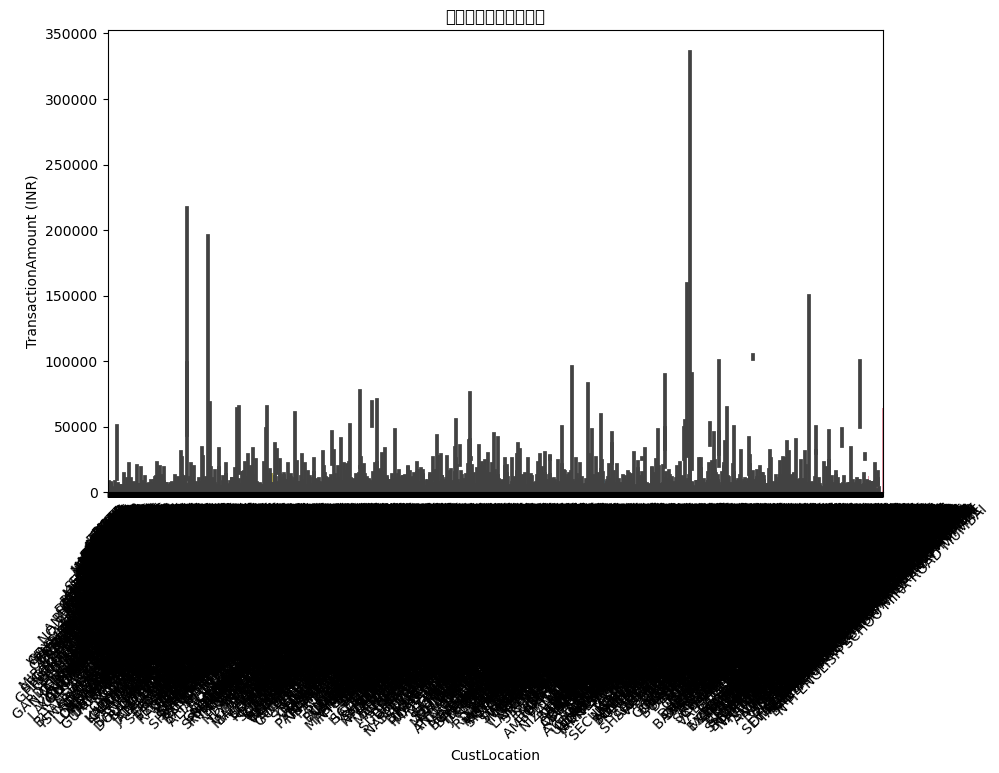

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(data=bank_customer, x='CustLocation', y='TransactionAmount (INR)', estimator=np.mean)
plt.xticks(rotation=45)
plt.title('不同地区的平均交易量')
plt.show()

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=bank_customer, x='Age', y='TransactionAmount (INR)')
plt.title('年龄与交易金额关系')
plt.show()


ValueError: Could not interpret value `Age` for parameter `x`

<Figure size 1000x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=bank_customer, x='Age', y='CustAccountBalance')
plt.title('年龄与账户余额关系')
plt.show()
